In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 #미니배치 크기
H = 3 #은닉 상태 벡터의 차원 수 
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) #재현이 가능하도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)


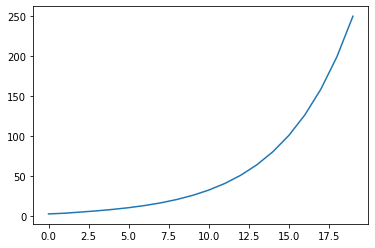

In [2]:
plt.plot(norm_list) #기울기 dh는 시간 크기에 비례하여 지수적으로 증가한다. 기울기 폭팔

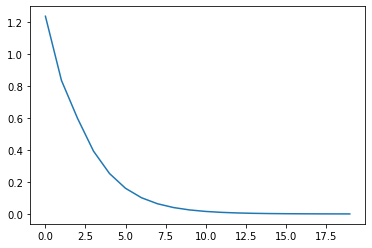

In [3]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 #미니배치 크기
H = 3 #은닉 상태 벡터의 차원 수 
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) #재현이 가능하도록 난수의 시드 고정
Wh = np.random.randn(H, H) * 0.5 #기울기 소실

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)

plt.plot(norm_list) #기울기 소실

In [4]:
#기울기 클리핑
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = npl.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1 :
        for grad in grads:
            grad *= rate

In [5]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        #slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H: 3*H]
        o = A[:, 3 * H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

In [6]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        self.h, self.c = None, None
        self,dh = None
        self.staeful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
    
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0,0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxc[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
            
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        self.dh = dh
        return dex
    
    def set_state(self, h, c=None):
        self.h, self.c = h,c
    
    def reset_state(self):
        self.h, self.c = None, None
    

In [7]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size = 10000, wordvec_size = 100, hidden_size = 100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        #가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        #계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        #모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.preict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f :
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.69
| 에폭 1 |  반복 21 / 1327 | 시간 4[s] | 퍼플렉서티 2965.93
| 에폭 1 |  반복 41 / 1327 | 시간 8[s] | 퍼플렉서티 1247.14
| 에폭 1 |  반복 61 / 1327 | 시간 13[s] | 퍼플렉서티 942.79
| 에폭 1 |  반복 81 / 1327 | 시간 17[s] | 퍼플렉서티 812.03
| 에폭 1 |  반복 101 / 1327 | 시간 22[s] | 퍼플렉서티 640.23
| 에폭 1 |  반복 121 / 1327 | 시간 26[s] | 퍼플렉서티 643.27
| 에폭 1 |  반복 141 / 1327 | 시간 31[s] | 퍼플렉서티 605.00
| 에폭 1 |  반복 161 / 1327 | 시간 35[s] | 퍼플렉서티 593.71
| 에폭 1 |  반복 181 / 1327 | 시간 40[s] | 퍼플렉서티 590.60
| 에폭 1 |  반복 201 / 1327 | 시간 45[s] | 퍼플렉서티 507.68
| 에폭 1 |  반복 221 / 1327 | 시간 50[s] | 퍼플렉서티 505.15
| 에폭 1 |  반복 241 / 1327 | 시간 54[s] | 퍼플렉서티 449.32
| 에폭 1 |  반복 261 / 1327 | 시간 59[s] | 퍼플렉서티 476.51
| 에폭 1 |  반복 281 / 1327 | 시간 64[s] | 퍼플렉서티 446.50
| 에폭 1 |  반복 301 / 1327 | 시간 69[s] | 퍼플렉서티 398.09
| 에폭 1 |  반복 321 / 1327 | 시간 74[s] | 퍼플렉서티 346.71
| 에폭 1 |  반복 341 / 1327 | 시간 79[s] | 퍼플렉서티 410.89
| 에폭 1 |  반복 361 / 1327 | 시간 84[s] | 퍼플렉서티 410.95
| 에폭 1 |  반복 381 / 1327 | 시간 89[s] | 퍼플렉서티 343.64
|

| 에폭 3 |  반복 541 / 1327 | 시간 803[s] | 퍼플렉서티 135.49
| 에폭 3 |  반복 561 / 1327 | 시간 809[s] | 퍼플렉서티 118.18
| 에폭 3 |  반복 581 / 1327 | 시간 816[s] | 퍼플렉서티 105.76
| 에폭 3 |  반복 601 / 1327 | 시간 823[s] | 퍼플렉서티 148.63
| 에폭 3 |  반복 621 / 1327 | 시간 831[s] | 퍼플렉서티 142.56
| 에폭 3 |  반복 641 / 1327 | 시간 838[s] | 퍼플렉서티 129.05
| 에폭 3 |  반복 661 / 1327 | 시간 845[s] | 퍼플렉서티 121.34
| 에폭 3 |  반복 681 / 1327 | 시간 851[s] | 퍼플렉서티 100.30
| 에폭 3 |  반복 701 / 1327 | 시간 857[s] | 퍼플렉서티 118.82
| 에폭 3 |  반복 721 / 1327 | 시간 863[s] | 퍼플렉서티 125.59
| 에폭 3 |  반복 741 / 1327 | 시간 869[s] | 퍼플렉서티 106.57
| 에폭 3 |  반복 761 / 1327 | 시간 877[s] | 퍼플렉서티 103.32
| 에폭 3 |  반복 781 / 1327 | 시간 883[s] | 퍼플렉서티 103.42
| 에폭 3 |  반복 801 / 1327 | 시간 889[s] | 퍼플렉서티 116.11
| 에폭 3 |  반복 821 / 1327 | 시간 894[s] | 퍼플렉서티 116.68
| 에폭 3 |  반복 841 / 1327 | 시간 900[s] | 퍼플렉서티 114.41
| 에폭 3 |  반복 861 / 1327 | 시간 906[s] | 퍼플렉서티 119.59
| 에폭 3 |  반복 881 / 1327 | 시간 912[s] | 퍼플렉서티 105.72
| 에폭 3 |  반복 901 / 1327 | 시간 918[s] | 퍼플렉서티 132.53
| 에폭 3 |  반복 921 / 1327 | 시간 92

C:\Users\qhrrl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qhrrl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qhrrl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qhrrl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qhrrl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qhrrl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49436 missing from c

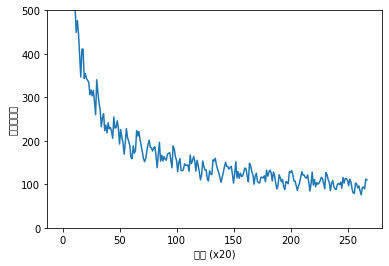

퍼플렉서티 평가 중 ...
234 / 235


NameError: name 'prit' is not defined

In [9]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

#하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

#학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

#모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

#기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval = 20)
trainer.plot(ylim=(0, 500))

#테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)

In [10]:
print('테스트 퍼플렉시티: ', ppl_test)

#매개변수 저장
model.save_params()

테스트 퍼플렉시티:  135.7747035347556
